>
> # MaaS Sim 
> * Multiplatform and decision
>
-----

In [15]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from MaaSSim.utils import get_config, load_G, save_config, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.decisions import f_platform_choice
from dotmap import DotMap
import random
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
plt.rcParams["font.family"] = "Times"
plt.style.use('seaborn-whitegrid')

In [19]:
params = get_config('../../data/config/delft.json')  # load configuration
params.city = 'Delft'
#params = make_config_paths(params)
params.simTime = 4 # 4 hours of simulation
params.nD = 1 # number of days to repeat
params.nP = 1 # reuqests (and passengers)
params.nV = 2 # vehicles
params.times.patience = 600 

In [20]:
res = pd.read_csv('pricing.csv', index_col = 0)
res.sample(3)

,fleet,fare,revenue,repl
262,20,1.0,26547.0,7
319,5,1.4,8292.0,9
267,25,1.0,39535.0,7


In [21]:
res['veh km'] = res['revenue']/100
res['revenue'] = res['veh km'] * res['fare']
res['revenue per driver'] = res['revenue']/res['fleet']
res['veh km per driver'] = res['veh km']/res['fleet']
res.groupby(['fleet','fare'])[['veh km','revenue', 'revenue per driver']].mean().unstack().round(1)

veh km                             revenue                              \
fare     0.6    0.8    1.0    1.2    1.4     0.6    0.8    1.0    1.2    1.4   
fleet                                                                          
5      197.1  180.3  156.9  136.9   88.6   118.3  144.2  156.9  164.3  124.1   
10     298.6  258.5  231.1  177.6  143.8   179.1  206.8  231.1  213.2  201.4   
15     357.0  324.6  286.3  208.1  181.5   214.2  259.7  286.3  249.7  254.2   
20     370.8  350.2  267.3  271.8  187.9   222.5  280.2  267.3  326.2  263.0   
25     393.9  393.7  323.9  278.7  194.1   236.3  314.9  323.9  334.4  271.7   
30     446.1  363.2  327.1  263.9  222.2   267.6  290.5  327.1  316.7  311.1   
40     438.5  453.3  340.6  307.5  282.4   263.1  362.6  340.6  369.0  395.3   

      revenue per driver                          
fare                 0.6   0.8   1.0   1.2   1.4  
fleet                                             
5                   23.7  28.8  31.4  32.9  24.8  
10                  17.9  20.7  23.1  21.3  20.1  
15                  14.3  17.3  19.1  16.6  16.9  
20                  11.1  14.0  13.4  16.3  13.2  
25                   9.5  12.6  13.0  13.4  10.9  
30                   8.9   9.7  10.9  10.6  10.4  
40                   6.6   9.1   8.5   9.2   9.9

'Darswk2_r' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

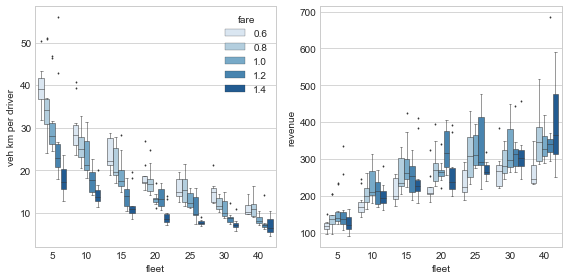

In [48]:
df = res
fig, ax = plt.subplots(1,2,figsize = (8,4))
sns.boxplot(hue='fare', y = 'veh km per driver', x = 'fleet', data  = res, 
             hue_order = df.fare.unique(),  palette = 'Blues', ax = ax[0], 
            linewidth = 0.5, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
#ax[0].set_xlim((5,40))
#ax[0].set_ylim((5,50))
sns.boxplot(hue='fare', y = 'revenue', x = 'fleet', data  = res, hue_order = df.fare.unique(),  
            palette = 'Blues', ax = ax[1], linewidth = 0.5, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
#ax[1].set_xlim((5,40))
#ax[1].set_ylim((100,500))
ax[1].legend().remove()
fig.tight_layout()
plt.savefig('e3.png')

-------------
Rafal Kucharski, 2020, Delft, r.m.kucharski@tudelft.nl